In [1]:
import math
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher

from config.utils import load_config


plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


CONFIG_PATH = './config/config.yaml'
WEIGHT_CLASSES = load_config(CONFIG_PATH).get("WEIGHT_CLASSES")
COLUMNS = load_config(CONFIG_PATH).get("FINAL_FRAME_COLUMNS")

## 1. Data Cleaning and Merging

### Fighters


* **name:** Fighter's Name
* **height:** Fighter's Height
* **weight:** Fighter's Weight
* **reach:** Fighter's Reach
* **stance:** Fighter's Stance
* **dob:** Fighter's Date Of Birth
* **str_lan_pm:** Significant Strikes Landed per Minute
* **str_abs_pm:** Significant Strikes Absorbed per Minute
* **str_acc:** Significant Striking Accuracy
* **str_def:** Significant Strike Defence (the % of opponents strikes that did not land)
* **tkdn_avg:** Average Takedowns Landed per 15 minutes
* **tkdn_acc:** Takedown Accuracy
* **tkdn_def:** Takedown Defense (the % of opponents TD attempts that did not land)
* **sub_avg:** Average Submissions Attempted per 15 minutes




In [2]:
fighters_df = pd.read_csv('./web_scrapers/fighters.csv', sep=',')
fighters_df.head()

name  height    weight reach    stance           dob  \
0         Tom Aaron      --  155 lbs.    --       NaN  Jul 13, 1978   
1      Danny Abbadi  5' 11"  155 lbs.    --  Orthodox  Jul 03, 1983   
2   Nariman Abbasov   5' 8"  155 lbs.   66"  Orthodox  Feb 01, 1994   
3      David Abbott   6' 0"  265 lbs.    --    Switch            --   
4  Hamdy Abdelwahab   6' 2"  264 lbs.   72"  Southpaw  Jan 22, 1993   

   str_lan_pm str_acc  str_abs_pm str_def  tkdn_avg tkdn_acc tkdn_def  sub_avg  
0        0.00      0%        0.00      0%      0.00       0%       0%     0.00  
1        3.29     38%        4.41     57%      0.00       0%      77%     0.00  
2        3.00     20%        5.67     46%      0.00       0%      66%     0.00  
3        1.35     30%        3.55     38%      1.07      33%      66%     0.00  
4        3.87     52%        3.13     59%      3.00      75%       0%     0.00

In [3]:
fighters_df.tail()

name height    weight reach    stance           dob  \
4107   Dave Zitanick     --  170 lbs.    --       NaN  Mar 05, 1980   
4108     Alex Zuniga     --  145 lbs.    --       NaN            --   
4109   George Zuniga  5' 9"  185 lbs.    --       NaN            --   
4110    Allan Zuniga  5' 7"  155 lbs.   70"  Orthodox  Apr 04, 1992   
4111  Virgil Zwicker  6' 2"  205 lbs.   74"       NaN  Jun 26, 1982   

      str_lan_pm str_acc  str_abs_pm str_def  tkdn_avg tkdn_acc tkdn_def  \
4107        0.00      0%        0.00      0%      0.00       0%       0%   
4108        0.00      0%        0.00      0%      0.00       0%       0%   
4109        7.64     38%        5.45     37%      0.00       0%     100%   
4110        3.93     52%        1.80     61%      0.00       0%      57%   
4111        3.34     48%        4.87     39%      1.31      30%      50%   

      sub_avg  
4107     0.00  
4108     0.00  
4109     0.00  
4110     1.00  
4111     0.00

In [4]:
fighters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        4112 non-null   object 
 1   height      4112 non-null   object 
 2   weight      4112 non-null   object 
 3   reach       4112 non-null   object 
 4   stance      3288 non-null   object 
 5   dob         4112 non-null   object 
 6   str_lan_pm  4112 non-null   float64
 7   str_acc     4112 non-null   object 
 8   str_abs_pm  4112 non-null   float64
 9   str_def     4112 non-null   object 
 10  tkdn_avg    4112 non-null   float64
 11  tkdn_acc    4112 non-null   object 
 12  tkdn_def    4112 non-null   object 
 13  sub_avg     4112 non-null   float64
dtypes: float64(4), object(10)
memory usage: 449.9+ KB


In [5]:
fighters_df.shape

(4112, 14)

In [6]:
# Removing duplicate entries
fighters_df = fighters_df.drop_duplicates().reset_index(drop=True)

In [7]:
fighters_df.loc[fighters_df.duplicated('name', keep=False)]

name  height    weight reach    stance           dob  \
821         Mike Davis      --        --    --       NaN            --   
826         Mike Davis   6' 0"  155 lbs.   72"  Orthodox  Oct 07, 1992   
1308        Joey Gomez  5' 10"  135 lbs.   73"  Orthodox  Jul 21, 1986   
1310        Joey Gomez  5' 10"  155 lbs.   71"  Orthodox  Aug 29, 1989   
1741      Tony Johnson   6' 2"  205 lbs.   76"  Orthodox  May 02, 1983   
1749      Tony Johnson   6' 1"  265 lbs.    --       NaN            --   
2327  Michael McDonald  5' 11"  205 lbs.    --  Orthodox  Feb 06, 1965   
2329  Michael McDonald   5' 9"  135 lbs.   70"  Orthodox  Jan 15, 1991   
3411        Jean Silva   5' 6"  160 lbs.    --  Orthodox  Oct 08, 1977   
3425       Bruno Silva   5' 4"  125 lbs.   65"  Orthodox  Mar 16, 1990   
3426       Bruno Silva   6' 0"  185 lbs.   74"  Orthodox  Jul 13, 1989   
3436        Jean Silva   5' 7"  145 lbs.   69"  Orthodox  Dec 27, 1996   

      str_lan_pm str_acc  str_abs_pm str_def  tkdn_avg tkdn_acc tkdn_def  \
821         0.00      0%        0.00      0%      0.00       0%       0%   
826         5.83     52%        6.20     56%      3.04      53%      69%   
1308        2.44     28%        4.46     55%      0.62     100%      50%   
1310        3.73     49%        3.33     50%      2.00      28%       0%   
1741        4.00     92%        3.67     22%      0.00       0%      90%   
1749        2.00     53%        4.73     31%      2.00      22%       0%   
2327        0.00      0%        0.40     50%      0.00       0%       0%   
2329        2.69     42%        2.76     57%      1.09      66%      52%   
3411        0.73     22%        2.93     52%      0.00       0%       0%   
3425        3.05     46%        3.09     59%      2.57      30%      64%   
3426        4.43     51%        5.33     43%      1.09      27%      73%   
3436        5.83     52%        4.27     57%      1.56      50%     100%   

      sub_avg  
821      0.00  
826      0.20  
1308     0.00  
1310     0.00  
1741     0.00  
1749     0.00  
2327     0.00  
2329     1.40  
3411     0.00  
3425     0.30  
3426     0.00  
3436     0.00

In [8]:
# Removing fighters with the same name
fighters_df = (
    fighters_df[~fighters_df.duplicated('name', keep=False)]
        .reset_index(drop=True)
)

In [9]:
def depercentize(x):
    return int(x[:-1]) / 100

# Casting 'str_acc','str_def','tkdn_acc', 'tkdn_def' to floats
fighters_df[['str_acc','str_def','tkdn_acc', 'tkdn_def']] = (
    fighters_df[['str_acc','str_def','tkdn_acc', 'tkdn_def']]
        .applymap(depercentize) 
)

In [10]:
# Replacing "--" with NaNs
fighters_df.replace('--', np.nan, inplace=True)

In [11]:
fighters_df[fighters_df.iloc[:,6] == 0].shape

(770, 14)

In [12]:
# Removing 770 fighters that haven't fought any fights
fighters_df = fighters_df[fighters_df.iloc[:,6] != 0]

In [13]:
# Dropping the "date of birth" column
# fighters_df.drop("dob", axis=1, inplace=True)

In [14]:
def height_to_cm(height_str):
    if pd.isna(height_str):
        return height_str
    feet, inches = [i[:-1] for i in height_str.split(' ')]
    return (int(feet) * 12 + int(inches)) * 2.54

# Casting "height" to centimeters
fighters_df['height'] = fighters_df['height'].apply(height_to_cm)

In [15]:
def get_weight_class(weight_str):
    if pd.isna(weight_str):
        return weight_str
    weight_value = int(weight_str.split(' ')[0])
    for key, weight_class in WEIGHT_CLASSES.items():
        if weight_value <= key:
            return weight_class

# Getting Class for "weight"
fighters_df['weight'] = fighters_df['weight'].apply(get_weight_class)

In [16]:
def reach_to_cm(reach_str):
    if pd.isna(reach_str):
        return reach_str
    reach = int(reach_str[:-1]) * 2.54
    return reach

# Casting "reach" to centimeters
fighters_df['reach'] = fighters_df['reach'].apply(reach_to_cm)

In [17]:
fighters_df.shape

(3330, 14)

In [18]:
fighters_df.head()

name  height       weight  reach    stance           dob  \
1         Danny Abbadi  180.34  Lightweight    NaN  Orthodox  Jul 03, 1983   
2      Nariman Abbasov  172.72  Lightweight 167.64  Orthodox  Feb 01, 1994   
3         David Abbott  182.88  Heavyweight    NaN    Switch           NaN   
4     Hamdy Abdelwahab  187.96  Heavyweight 182.88  Southpaw  Jan 22, 1993   
5  Shamil Abdurakhimov  190.50  Heavyweight 193.04  Orthodox  Sep 02, 1981   

   str_lan_pm  str_acc  str_abs_pm  str_def  tkdn_avg  tkdn_acc  tkdn_def  \
1        3.29     0.38        4.41     0.57      0.00      0.00      0.77   
2        3.00     0.20        5.67     0.46      0.00      0.00      0.66   
3        1.35     0.30        3.55     0.38      1.07      0.33      0.66   
4        3.87     0.52        3.13     0.59      3.00      0.75      0.00   
5        2.41     0.44        3.02     0.55      1.01      0.23      0.45   

   sub_avg  
1     0.00  
2     0.00  
3     0.00  
4     0.00  
5     0.10

In [19]:
numerical_columns = fighters_df.select_dtypes(exclude='object').columns
categorical_columns = fighters_df.select_dtypes(include='object').columns
numerical_columns, categorical_columns

(Index(['height', 'reach', 'str_lan_pm', 'str_acc', 'str_abs_pm', 'str_def',
        'tkdn_avg', 'tkdn_acc', 'tkdn_def', 'sub_avg'],
       dtype='object'),
 Index(['name', 'weight', 'stance', 'dob'], dtype='object'))

In [20]:
# Filling in missing categorical values with the most frequent ones
for col in categorical_columns:
    fighters_df[col] = (
        fighters_df[col].fillna(fighters_df[col].value_counts().index[0])
    )
cat_cols = fighters_df[categorical_columns]

In [21]:
# Filling in missing values with KNNImputer
imputer = KNNImputer(n_neighbors=40)
knn_data = imputer.fit_transform(
    fighters_df[numerical_columns]
)
num_cols = pd.DataFrame(
    knn_data, 
    columns=numerical_columns, 
    index=fighters_df.index
)

In [22]:
fighters_df = pd.concat((cat_cols, num_cols), axis=1).reset_index(drop=True)

In [23]:
fighters_df.head()

name       weight    stance           dob  height  reach  \
0         Danny Abbadi  Lightweight  Orthodox  Jul 03, 1983  180.34 184.98   
1      Nariman Abbasov  Lightweight  Orthodox  Feb 01, 1994  172.72 167.64   
2         David Abbott  Heavyweight    Switch  Aug 08, 1988  182.88 187.96   
3     Hamdy Abdelwahab  Heavyweight  Southpaw  Jan 22, 1993  187.96 182.88   
4  Shamil Abdurakhimov  Heavyweight  Orthodox  Sep 02, 1981  190.50 193.04   

   str_lan_pm  str_acc  str_abs_pm  str_def  tkdn_avg  tkdn_acc  tkdn_def  \
0        3.29     0.38        4.41     0.57      0.00      0.00      0.77   
1        3.00     0.20        5.67     0.46      0.00      0.00      0.66   
2        1.35     0.30        3.55     0.38      1.07      0.33      0.66   
3        3.87     0.52        3.13     0.59      3.00      0.75      0.00   
4        2.41     0.44        3.02     0.55      1.01      0.23      0.45   

   sub_avg  
0     0.00  
1     0.00  
2     0.00  
3     0.00  
4     0.10

In [24]:
fighters_df.describe(exclude='object')

height   reach  str_lan_pm  str_acc  str_abs_pm  str_def  tkdn_avg  \
count 3330.00 3330.00     3330.00  3330.00     3330.00  3330.00   3330.00   
mean   178.01  182.30        3.00     0.44        3.72     0.51      1.50   
std      8.85    9.88        1.77     0.12        2.46     0.12      1.94   
min    152.40  147.32        0.06     0.04        0.00     0.00      0.00   
25%    172.72  175.26        1.74     0.36        2.34     0.45      0.00   
50%    177.80  182.88        2.79     0.44        3.29     0.53      1.00   
75%    182.88  188.90        3.90     0.50        4.52     0.59      2.17   
max    226.06  213.36       17.65     1.00       49.41     1.00     24.11   

       tkdn_acc  tkdn_def  sub_avg  
count   3330.00   3330.00  3330.00  
mean       0.32      0.48     0.70  
std        0.28      0.32     1.47  
min        0.00      0.00     0.00  
25%        0.00      0.22     0.00  
50%        0.33      0.52     0.20  
75%        0.50      0.71     0.90  
max        1.00      1.00    21.60

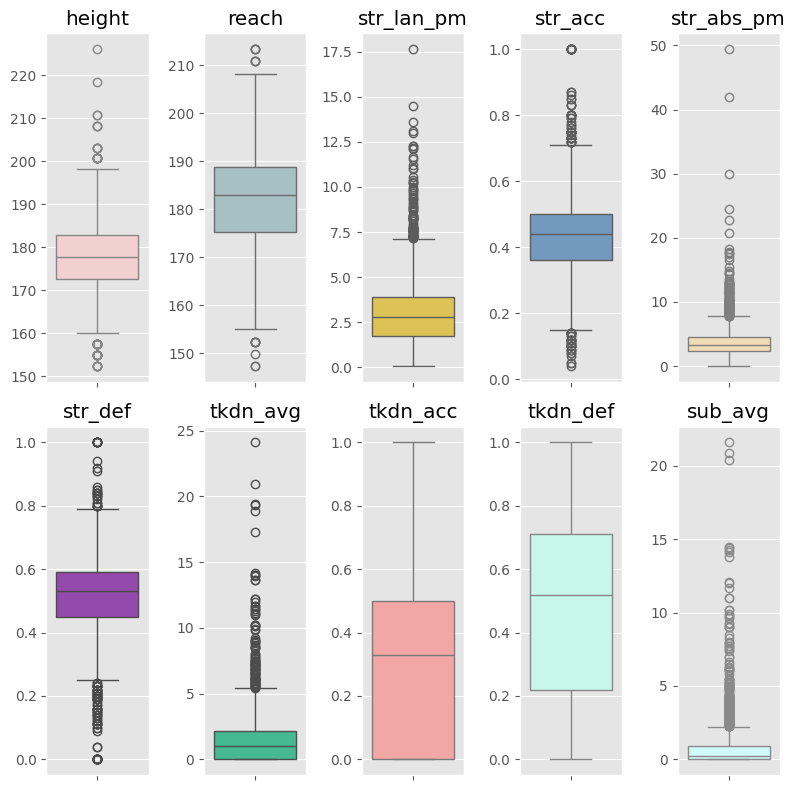

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 8))

for i, col in enumerate(numerical_columns):
    colors = [
    "#F7CAC9",  # Soft peachy pink
    "#A2C4C9",  # Cool teal blue
    "#F4D03F",  # Bright yellow
    "#6699CC",  # Deep navy blue
    "#FADEAD",  # Pale lavender
    "#9D38BD",  # Vibrant purple
    "#33CC99",  # Minty green
    "#FF9999",  # Cherry red
    "#C0FFEE",  # Creamy coffee brown
    "#CCFFFF"   # Light sky blue
    ]
    ax = axes.flat[i]
    sns.boxplot(
        y=col, 
        data=fighters_df, 
        ax=ax,
        color=colors[i]
    )
    ax.set_title(col)
    ax.set(ylabel='')
plt.tight_layout()

plt.show()    

##### Stats overview:
Some outliers represent natural variations in the population, and they should be left as is in a dataset. These are called true outliers.
While removing outliers might marginally improve model performance for most average fighters, it would sacrifice accuracy for champions and struggling athletes. Since we anticipate encountering both extremes in future data, preserving outliers remains crucial.


In [26]:
fighters_df.describe(include='object')

name       weight    stance           dob
count           3330         3330      3330          3330
unique          3330            8         5          2601
top     Danny Abbadi  Lightweight  Orthodox  Aug 08, 1988
freq               1          576      2625           304

##### Stats overview:
The most commin weight category and stance are Lightweight and Orthodox respectively which makes sense.

#

### Events


* **event:** Event Name
* **date:** Event Date
* **favourite:** Favourite Name
* **favourite_odds:** Favourite Odds
* **underdog:** Underdog Name
* **underdog_odds:** Underdog Odds
* **result:** Fight Result



In [27]:
events_df = pd.read_csv('./web_scrapers/odds.csv', sep=',')
events_df.head()

event           date        favourite  favourite_odds  \
0  UFC 159 - Jones vs. Sonnen  27th Apr 2013        Jon Jones            1.13   
1  UFC 159 - Jones vs. Sonnen  27th Apr 2013  Michael Bisping            1.57   
2  UFC 159 - Jones vs. Sonnen  27th Apr 2013       Roy Nelson            1.43   
3  UFC 159 - Jones vs. Sonnen  27th Apr 2013       Phil Davis            1.36   
4  UFC 159 - Jones vs. Sonnen  27th Apr 2013       Jim Miller            1.40   

          underdog  underdog_odds     result  
0     Chael Sonnen           9.00  Favourite  
1     Alan Belcher           4.50  Favourite  
2     Cheick Kongo           3.20  Favourite  
3  Vinny Magalhaes           3.55  Favourite  
4        Pat Healy           3.40   Underdog

In [28]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201 entries, 0 to 4200
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event           4201 non-null   object 
 1   date            4201 non-null   object 
 2   favourite       4201 non-null   object 
 3   favourite_odds  4201 non-null   float64
 4   underdog        4201 non-null   object 
 5   underdog_odds   4201 non-null   float64
 6   result          4201 non-null   object 
dtypes: float64(2), object(5)
memory usage: 229.9+ KB


In [29]:
events_df.shape

(4201, 7)

In [30]:
# Removing duplicate entries
events_df = events_df.drop_duplicates().reset_index(drop=True)

In [31]:
# Removing "event" column
events_df = events_df.drop('event', axis=1)

In [32]:
events_df[
    (events_df.favourite_odds == np.inf) | 
    (events_df.underdog_odds == np.inf)
]

date            favourite  favourite_odds  \
459   18th Jan 2015        Frankie Perez             inf   
1620   8th Jul 2017      Aleksei Oleinik             inf   
1638  16th Jul 2017          Danny Henry             inf   
1689  22nd Sep 2017         Dong Hyun Ma             inf   
1723   4th Nov 2017          Paulo Costa             inf   
1726   4th Nov 2017       Curtis Blaydes             inf   
1772   2nd Dec 2017       Melinda Fabian             inf   
1877  18th Feb 2018           Geoff Neal             inf   
2029   7th Jul 2018          Urijah Hall             inf   
2136  22nd Sep 2018     Luigi Vendramini             inf   
2220  30th Nov 2018          Leah Letson             inf   
2271  29th Dec 2018          Bevon Lewis             inf   
2297   2nd Feb 2019       Felipe Colares             inf   
2305   9th Feb 2019        Devonte Smith             inf   
2369  16th Mar 2019     Saparbek Safarov             inf   
2423  27th Apr 2019     Dmitry Smoliakov             inf   
2609  31st Aug 2019         Mizuki Inoue             inf   
2750  16th Nov 2019     Isabela de Padua             inf   
3037  22nd Aug 2020        Carlton Minus             inf   
3066  19th Sep 2020         T.J. Laramie             inf   
3285   1st May 2021            KB Bhular             inf   
3309  22nd May 2021  Juancamilo Ronderos             inf   
3334  17th Jul 2021          Alan Baudot             inf   
3385   2nd Oct 2021         Mike Breeden             inf   
3390   2nd Oct 2021     Gaetano Pirrello             inf   
3551  16th Apr 2022           Trey Ogden             inf   
3567  21st May 2022      Dusko Todorovic             inf   
3571  21st May 2022        Parker Porter             inf   
3619   2nd Jul 2022        Gabriel Green             inf   
3621   2nd Jul 2022          Urijah Hall             inf   
3712  17th Sep 2022         Tanner Boser             inf   
3787   3rd Dec 2022        Genaro Valdez             inf   
3910   6th May 2023       Rolando Bedoya             inf   
4051  12th Aug 2023         Jose Johnson             inf   
4058  26th Aug 2023        Parker Porter             inf   
4059  26th Aug 2023       Lukasz Brzeski             inf   
4173   9th Dec 2023          Carlos Vera             inf   
4200  20th Jan 2024        Carlos Ulberg             inf   

                         underdog  underdog_odds      result  
459                   Johnny Case            inf    Underdog  
1620                Travis Browne            inf   Favourite  
1638                Daniel Teymur            inf   Favourite  
1689                Takanori Gomi            inf   Favourite  
1723              Johny Hendricks            inf   Favourite  
1726              Aleksei Oleinik            inf   Favourite  
1772               DeAnna Bennett            inf        Draw  
1877                Brian Camozzi            inf   Favourite  
2029                  Paulo Costa            inf    Underdog  
2136    Elizeu Zaleski dos Santos            inf    Underdog  
2220           Julija Stoliarenko            inf   Favourite  
2271                  Urijah Hall            inf    Underdog  
2297       Geraldo De Freitas Jr.            inf    Underdog  
2305                 Dong Hyun Ma            inf   Favourite  
2369             Nick Negumereanu            inf   Favourite  
2423                   Greg Hardy            inf    Underdog  
2609                     Yanan Wu            inf   Favourite  
2750                Ariane Lipski            inf    Underdog  
3037            Matt Semelsberger            inf    Underdog  
3066               Darrick Minner            inf    Underdog  
3285          Andreas Michailidis            inf    Underdog  
3309                 David Dvorak            inf    Underdog  
3334  Rodrigo Nascimento Ferreira            inf    Underdog  
3385          Alexander Hernandez            inf    Underdog  
3390     Douglas Silva de Andrade            inf    Underdog  
3551               Jordan Leavitt   

In [33]:
events_df[
    (events_df.favourite_odds == np.inf) | 
    (events_df.underdog_odds == np.inf)
    ].shape

(38, 6)

In [34]:
# Removing 37 entries with NaNs 
# in either "favourite_odds" or "underdog_odds" columns
events_df = events_df[
    (events_df.favourite_odds != np.inf) | 
    (events_df.underdog_odds != np.inf)
]

In [35]:
# Converting "date" column to datetime type
events_df.date = pd.to_datetime(
    events_df.date.replace({'(st|nd|rd|th)': ''}, regex=True), 
    format="%d %b %Y"
)

### Feature Engeneering

In [36]:
def get_fighter_ann_wins(entry, df, fighter_type):

    previous_day = entry.date - timedelta(days=1)
    a_year_ago = df.date - timedelta(days=364)
    fighter_type = entry[f"{fighter_type}"]

    wins = df.loc[
        (df.date > a_year_ago) & (df.date <= previous_day)
    ].loc[
        ((df.favourite == fighter_type) & (df.result == 'Favourite')) | 
        ((df.underdog == fighter_type) & (df.result == 'Underdog'))
    ].shape[0]

    return wins

# Getting favourite's annual wins count
events_df['fav_ann_wins'] = events_df.apply(
    lambda row: get_fighter_ann_wins(row, events_df, "favourite"), axis=1
)

# Getting underdog's annual wins count
events_df['und_ann_wins'] = events_df.apply(
    lambda row: get_fighter_ann_wins(row, events_df, "underdog"), axis=1  
)

# Getting difference between them
events_df['ann_wins_diff'] = (
    events_df['fav_ann_wins'] - events_df['und_ann_wins']
)

# Dropping the columns that we don't need anymore
events_df.drop(['fav_ann_wins', 'und_ann_wins'], axis=1, inplace=True)

In [37]:
# Sorting by "date" column
events_df = events_df.sort_values("date", ascending=True)

# Setting "date" as index
events_df.set_index('date')

favourite  favourite_odds            underdog  \
date                                                                   
2013-04-27             Jon Jones            1.13        Chael Sonnen   
2013-04-27          Steven Siler            1.95      Kurt Holobaugh   
2013-04-27        Leonard Garcia            1.53       Cody McKenzie   
2013-04-27           Sara McMann            1.18         Sheila Gaff   
2013-04-27       Ovince St Preux            1.69       Gian Villante   
...                          ...             ...                 ...   
2024-01-20     Mayra Bueno Silva            1.62   Raquel Pennington   
2024-01-20     Dricus Du Plessis            1.93     Sean Strickland   
2024-01-20  Jasmine Jasudavicius            1.27  Priscila Cachoeira   
2024-01-20         Movsar Evloev            1.54        Arnold Allen   
2024-01-20        Malcolm Gordon            1.51         Jimmy Flick   

            underdog_odds     result  ann_wins_diff  
date                                                 
2013-04-27           9.00  Favourite              0  
2013-04-27           2.06  Favourite              0  
2013-04-27           2.93   Underdog              0  
2013-04-27           5.80  Favourite              0  
2013-04-27           2.40  Favourite              0  
...                   ...        ...            ...  
2024-01-20           2.55   Underdog             -4  
2024-01-20           1.97  Favourite             -6  
2024-01-20           4.40  Favourite              1  
2024-01-20           2.80  Favourite             -3  
2024-01-20           2.80   Underdog              0  

[4163 rows x 6 columns]

In [38]:
events_df.shape

(4163, 7)

In [39]:
events_df.describe(exclude='object')

date  favourite_odds  underdog_odds  \
count                           4163         4163.00        4163.00   
mean   2018-09-13 20:13:46.711506176            1.55           3.22   
min              2013-04-27 00:00:00            1.06           1.88   
25%              2016-04-23 00:00:00            1.37           2.35   
50%              2018-08-25 00:00:00            1.56           2.78   
75%              2020-11-14 00:00:00            1.72           3.60   
max              2024-01-20 00:00:00            2.50          14.05   
std                              NaN            0.23           1.36   

       ann_wins_diff  
count        4163.00  
mean            0.20  
min           -13.00  
25%            -1.00  
50%             0.00  
75%             1.00  
max            13.00  
std             2.53

##### Stats overview:
Nothing out of ordinary for this data. Favourite odds are always lower than underdog odds. Underdog's max odds score is somewhat high meaning that there is at least an occurence of a fighter in the set who might be too old or on a loosing steak at the moment of the event. We will keep this outlier intact as we may receive similiar entries in the future data

In [40]:
events_df.describe(include='object')

favourite         underdog     result
count           4163             4163       4163
unique          1216             1388          4
top     Max Holloway  Andrei Arlovski  Favourite
freq              15               21       2686

##### Stats overview:
In rougthly 2/3 of the fights favourite wins. There are vetetran fighters such as Arlovski who's been fighting for around 20 years now while leaving their prime years way behind

In [41]:
# Merging favourites with events 
df = pd.merge(
    events_df, 
    fighters_df, 
    how='inner', 
    left_on='favourite', 
    right_on='name'
)

In [42]:
# Merging underdogs with events 
df = pd.merge(
    df, 
    fighters_df, 
    how='inner', 
    left_on='underdog', 
    right_on='name', 
    suffixes=['',"_u"]
)

In [43]:
# Creating difference columns
df['odds_diff'] = df['favourite_odds'] - df['underdog_odds']
df['height_diff'] = df['height'] - df['height_u']  
df['reach_diff'] = df['reach'] - df['reach_u']
df['str_lan_diff'] = df['str_lan_pm'] - df['str_lan_pm_u']
df['str_acc_diff'] = df['str_acc'] - df['str_acc_u']  
df['str_abs_diff'] = df['str_abs_pm'] - df['str_abs_pm_u']
df['str_def_diff'] = df['str_def'] - df['str_def_u']
df['tkdn_avg_diff'] = df['tkdn_avg'] - df['tkdn_avg_u']
df['tkdn_acc_diff'] = df['tkdn_acc'] - df['tkdn_acc_u']
df['tkdn_def_diff'] = df['tkdn_def'] - df['tkdn_def_u'] 
df['sub_avg_diff'] = df['sub_avg'] - df['sub_avg_u']

In [44]:
# Dropping original columns
df.drop(['favourite_odds', 'underdog_odds', 'name', 'name_u', 'weight_u',
         'height', 'height_u', 'reach', 'reach_u', 
         'str_lan_pm', 'str_lan_pm_u', 'str_acc', 'str_acc_u',  
         'str_abs_pm', 'str_abs_pm_u', 'str_def', 'str_def_u',
         'tkdn_avg', 'tkdn_avg_u', 'tkdn_acc', 'tkdn_acc_u',
         'tkdn_def', 'tkdn_def_u', 'sub_avg', 'sub_avg_u'], 
        axis=1, inplace=True)

In [45]:
# Renaming "stance" column
df.rename(columns={"stance":"stance_f"}, inplace = True)

In [46]:
df.tail()

date        favourite        underdog     result  ann_wins_diff  \
3513 2023-11-18   Payton Talbott    Nick Aguirre  Favourite              0   
3514 2023-12-02  Rodolfo Bellato   Ihor Potieria  Favourite              0   
3515 2023-12-09   Rayanne Amanda  Talita Alencar   Underdog              0   
3516 2024-01-20   Yohan Lainesse   Sam Patterson   Underdog              0   
3517 2024-01-20     Serhiy Sidey   Ramon Taveras   Underdog              0   

                 weight  stance_f           dob  stance_u         dob_u  \
3513       Bantamweight    Switch  Sep 09, 1998  Southpaw  Jan 15, 1996   
3514  Light Heavyweight  Orthodox  Feb 05, 1996  Southpaw  May 29, 1996   
3515          Flyweight  Orthodox  Jun 08, 1995  Orthodox  Oct 17, 1990   
3516       Welterweight  Orthodox  Aug 14, 1992  Orthodox  Apr 30, 1996   
3517       Bantamweight    Switch  Jul 04, 1996  Southpaw  Jan 09, 1994   

      odds_diff  height_diff  reach_diff  str_lan_diff  str_acc_diff  \
3513      -5.86         2.54      -10.16          5.93          0.18   
3514      -3.25         0.00        5.08          0.88          0.05   
3515      -0.71         2.54       10.16          1.36          0.08   
3516      -0.52        -5.08       -5.08         -0.22          0.06   
3517      -1.24         7.62        5.08         -2.68         -0.23   

      str_abs_diff  str_def_diff  tkdn_avg_diff  tkdn_acc_diff  tkdn_def_diff  \
3513          0.23          0.06          -1.16          -0.20           0.55   
3514         -0.66          0.03           1.09           0.25           0.43   
3515         -0.17          0.17          -2.00           0.05           0.38   
3516         -0.54          0.15           1.00           0.28           0.47   
3517         -1.65         -0.24           0.00           0.00           0.00   

      sub_avg_diff  
3513          0.00  
3514          0.50  
3515          0.00  
3516         -2.30  
3517          0.00

## 2. Exploratory Data Analysis

In [47]:
df.describe(include='object')

favourite         underdog     result        weight  stance_f  \
count              3518             3518       3518          3518      3518   
unique             1066             1218          4             8         3   
top     Israel Adesanya  Andrei Arlovski  Favourite  Welterweight  Orthodox   
freq                 15               20       2259           587      2620   

                 dob  stance_u         dob_u  
count           3518      3518          3518  
unique           985         3          1108  
top     Jul 22, 1989  Orthodox  Feb 04, 1979  
freq              20      2637            20

In [48]:
df.describe(exclude='object')

date  ann_wins_diff  odds_diff  height_diff  \
count                           3518        3518.00    3518.00      3518.00   
mean   2018-08-09 19:20:01.364411648           0.22      -1.66         0.25   
min              2013-04-27 00:00:00         -13.00     -12.95       -22.86   
25%              2016-03-19 00:00:00          -1.00      -2.24        -2.54   
50%              2018-07-07 00:00:00           0.00      -1.22         0.00   
75%              2020-10-04 00:00:00           1.00      -0.64         5.08   
max              2024-01-20 00:00:00          13.00       0.00        27.94   
std                              NaN           2.54       1.55         6.26   

       reach_diff  str_lan_diff  str_acc_diff  str_abs_diff  str_def_diff  \
count     3518.00       3518.00       3518.00       3518.00       3518.00   
mean         0.57          0.34          0.02         -0.28          0.02   
min        -27.62         -6.10         -0.33         -8.74         -0.31   
25%         -5.08         -0.70         -0.05         -1.24         -0.04   
50%          0.00          0.34          0.02         -0.23          0.01   
75%          5.08          1.34          0.08          0.71          0.07   
max         30.48          8.99          0.39         12.64          0.45   
std          8.14          1.59          0.10          1.57          0.09   

       tkdn_avg_diff  tkdn_acc_diff  tkdn_def_diff  sub_avg_diff  
count        3518.00        3518.00        3518.00       3518.00  
mean            0.26           0.04           0.06          0.03  
min           -10.44          -1.00          -1.00        -11.60  
25%            -0.76          -0.11          -0.12         -0.40  
50%             0.14           0.04           0.05          0.00  
75%             1.20           0.20           0.23          0.40  
max            11.01           1.00           1.00         13.70  
std             1.76           0.26           0.28          0.87

In [49]:
numerical_columns = (
    df.select_dtypes(exclude='object').columns.to_list()[1:]
)
categorical_columns = (
    df.select_dtypes(include='object').columns.drop('result').to_list()
)
numerical_columns, categorical_columns

(['ann_wins_diff',
  'odds_diff',
  'height_diff',
  'reach_diff',
  'str_lan_diff',
  'str_acc_diff',
  'str_abs_diff',
  'str_def_diff',
  'tkdn_avg_diff',
  'tkdn_acc_diff',
  'tkdn_def_diff',
  'sub_avg_diff'],
 ['favourite', 'underdog', 'weight', 'stance_f', 'dob', 'stance_u', 'dob_u'])

In [50]:
# One Hot Encoding stance columns
for col in ['stance_f','stance_u']:
    one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

In [51]:
weight_class_to_number = {
    weight_class: i + 1 
        for i, weight_class in enumerate(WEIGHT_CLASSES.values())
}

# Ordinal Encoding "weight" column
df['weight'] = df['weight'].map(weight_class_to_number)

In [52]:
# Encoding fighter names for favourites 
fighter_names = df["favourite"].apply(lambda name: {"name": name})

# Hashing names into 10 features
hasher = FeatureHasher(n_features=10) 
encoded_f = hasher.transform(fighter_names).toarray()

enc_df = pd.DataFrame(encoded_f, columns=[f"favourite_{i}" for i in range(10)])

# Adding encoded favourite features to dataframe
df = pd.concat([df, enc_df], axis=1)


# Encoding fighter names for underdogs
fighter_names = df["underdog"].apply(lambda name: {"name": name})

# Hashing names into 10 features 
hasher = FeatureHasher(n_features=10)
encoded_u = hasher.transform(fighter_names).toarray() 

enc_df = pd.DataFrame(encoded_u, columns=[f"underdog_{i}" for i in range(10)])

# Adding encoded underdog features to dataframe
df = pd.concat([df, enc_df], axis=1)

# Dropping columns that we don't need anymore
df.drop(["favourite", "underdog"],axis=1,inplace=True)

In [53]:
df.head()

date     result  ann_wins_diff  weight           dob         dob_u  \
0 2013-04-27  Favourite              0       8  Jul 19, 1987  Apr 03, 1977   
1 2013-08-17   Underdog              0       7  Nov 25, 1981  Apr 03, 1977   
2 2013-11-16  Favourite             -1       7  Sep 25, 1979  Apr 03, 1977   
3 2014-04-26  Favourite              0       8  Jul 19, 1987  Oct 28, 1979   
4 2019-09-14   Underdog             -1       7  Mar 07, 1992  Oct 28, 1979   

   odds_diff  height_diff  reach_diff  str_lan_diff  str_acc_diff  \
0      -7.87         7.62       27.94          1.21          0.14   
1      -0.88         0.00        7.62          0.49          0.07   
2      -1.70        -2.54        5.08         -0.94         -0.06   
3      -3.81         5.08       20.32          0.56          0.08   
4      -0.07         2.54        2.54          0.65          0.06   

   str_abs_diff  str_def_diff  tkdn_avg_diff  tkdn_acc_diff  tkdn_def_diff  \
0          1.12          0.02          -1.88          -0.14           0.29   
1          1.69         -0.08          -1.80          -0.11          -0.17   
2          1.32          0.01          -0.83          -0.15           0.07   
3         -2.21          0.13          -0.18           0.12           0.35   
4         -1.96         -0.07           0.18           0.05          -0.07   

   sub_avg_diff  stance_f_Southpaw  stance_f_Switch  stance_u_Southpaw  \
0          0.10              False            False               True   
1          0.30              False            False               True   
2         -0.40              False            False               True   
3         -0.40              False            False              False   
4          0.50              False            False              False   

   stance_u_Switch  favourite_0  favourite_1  favourite_2  favourite_3  \
0            False         0.00         0.00         0.00         0.00   
1            False         0.00         0.00         0.00         0.00   
2            False         0.00         0.00         0.00         0.00   
3            False         0.00         0.00         0.00         0.00   
4            False         0.00         0.00         0.00         0.00   

   favourite_4  favourite_5  favourite_6  favourite_7  favourite_8  \
0         0.00         0.00         0.00         0.00         0.00   
1        -1.00         0.00         0.00         0.00         0.00   
2         0.00         0.00         0.00         0.00         1.00   
3         0.00         0.00         0.00         0.00         0.00   
4         0.00         0.00         0.00         0.00         0.00   

   favourite_9  underdog_0  underdog_1  underdog_2  underdog_3  underdog_4  \
0         1.00        0.00        0.00        1.00        0.00        0.00   
1         0.00        0.00        0.00        1.00        0.00        0.00   
2         0.00        0.00        0.00        1.00        0.00        0.00   
3         1.00        0.00        0.00        0.00        0.00        0.00   
4         1.00        0.00        0.00        0.00        0.00        0.00   

   underdog_5  underdog_6  underdog_7  underdog_8  underdog_9  
0        0.00        0.00        0.00        0.00        0.00  
1        0.00        0.00        0.00        0.00        0.00  
2        0.00        0.00        0.00        0.00        0.00  
3        0.00        0.00        0.00       -1.00        0.00  
4        0.00        0.00        0.00       -1.00        0.00

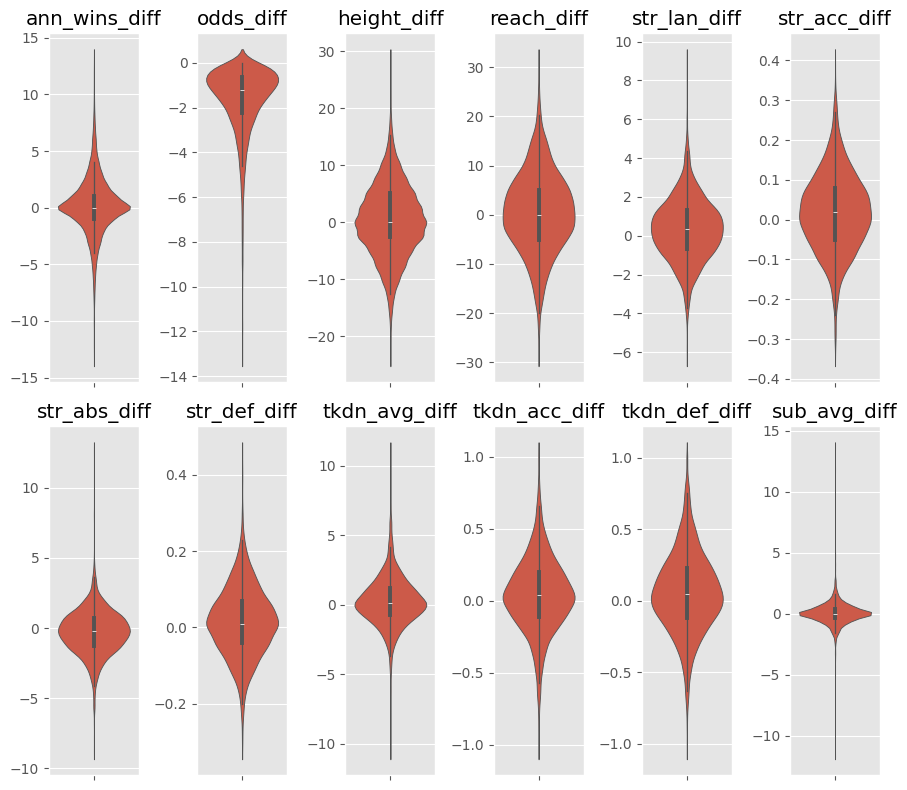

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(9, 8))

for i, col in enumerate(numerical_columns):
    ax = axes.flat[i]
    sns.violinplot(y=col, data=df, ax=ax)
    ax.set_title(col)
    ax.set(ylabel='')
plt.tight_layout()

plt.show()    

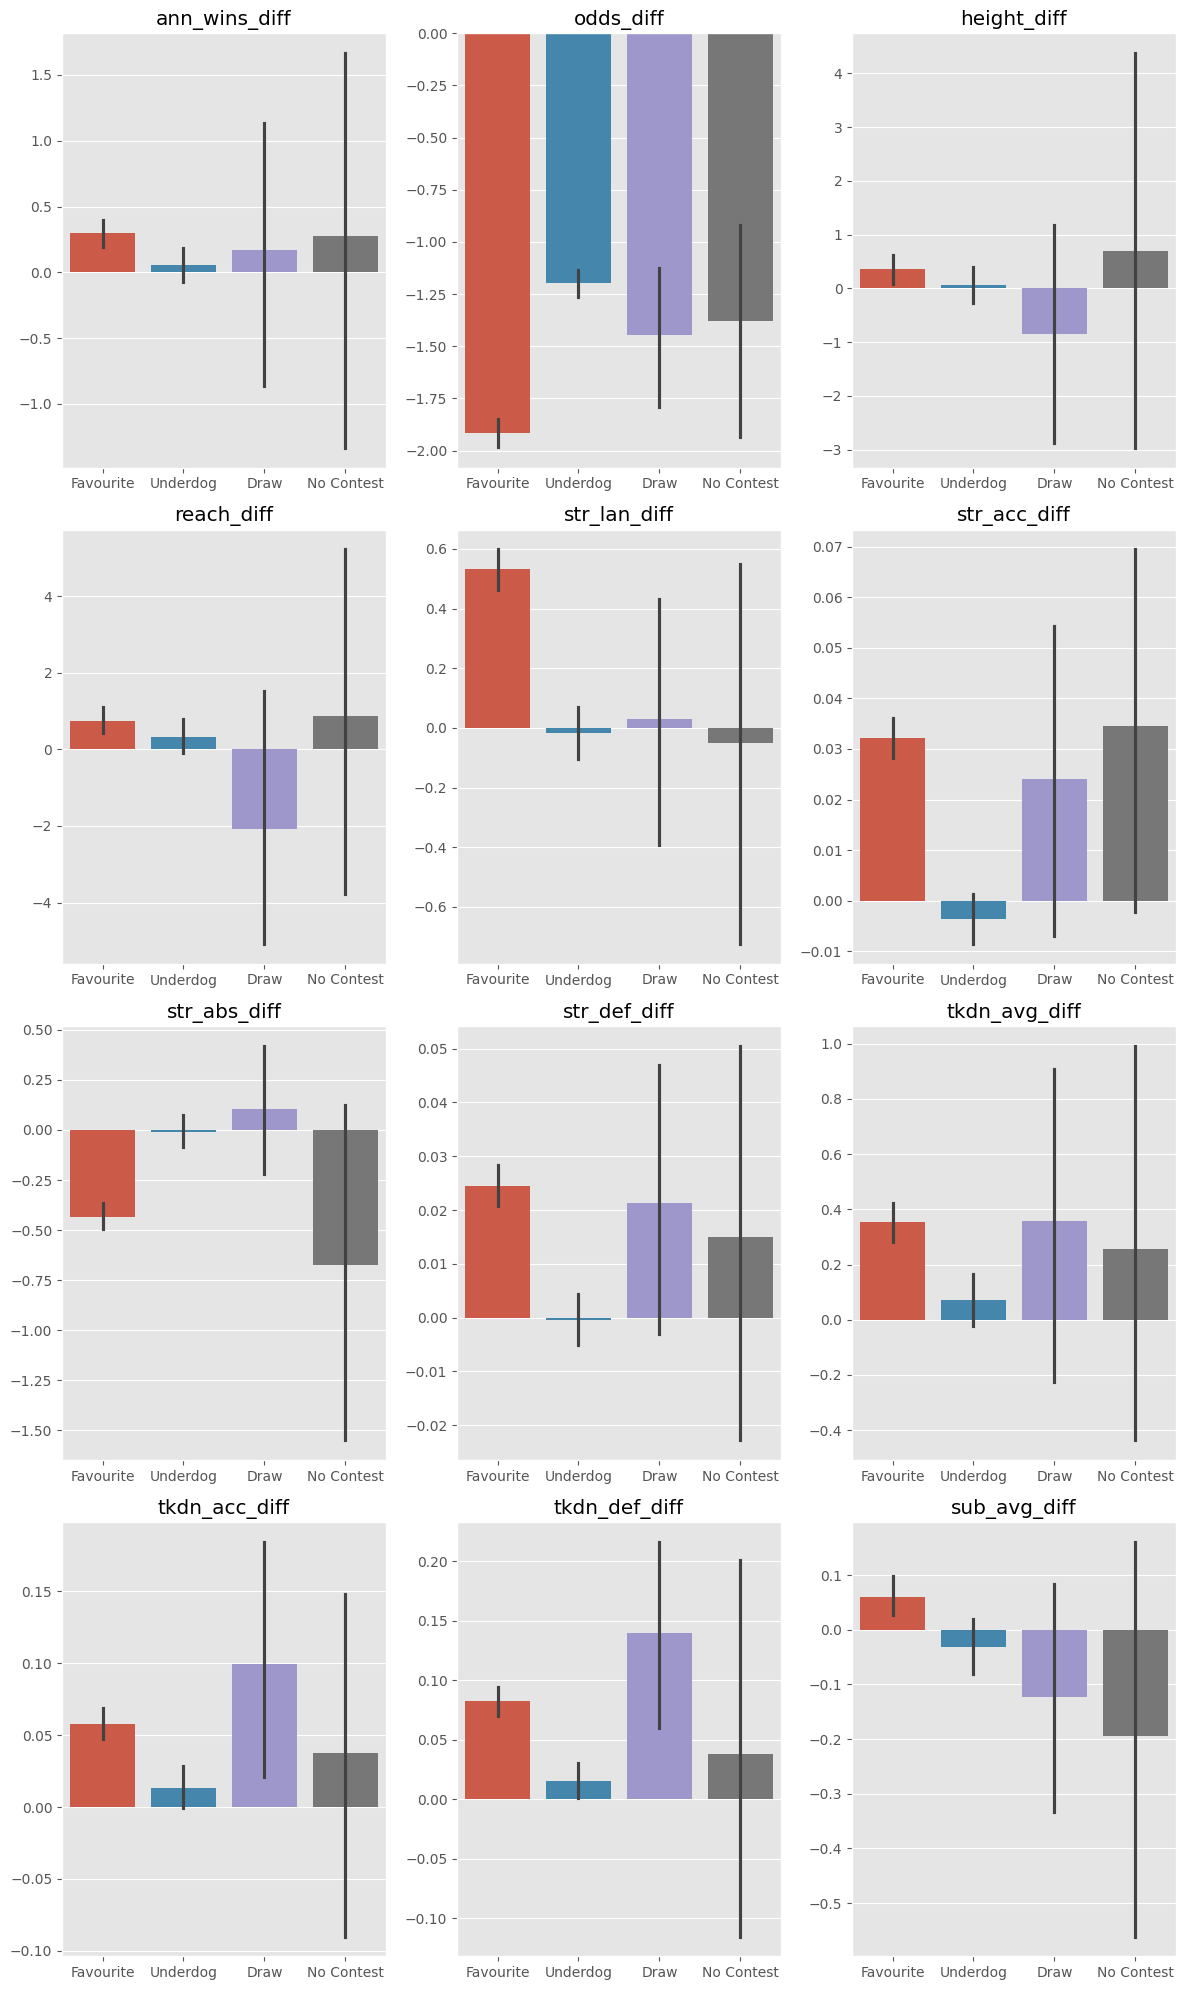

In [55]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 20))

for i, col in enumerate(numerical_columns):
    ax = axes.flat[i]
    sns.barplot(x='result', y=col, data=df, hue='result', ax=ax)
    ax.set_title(col)
    ax.set(ylabel='')
    ax.set(xlabel='')
plt.tight_layout()

plt.show()  

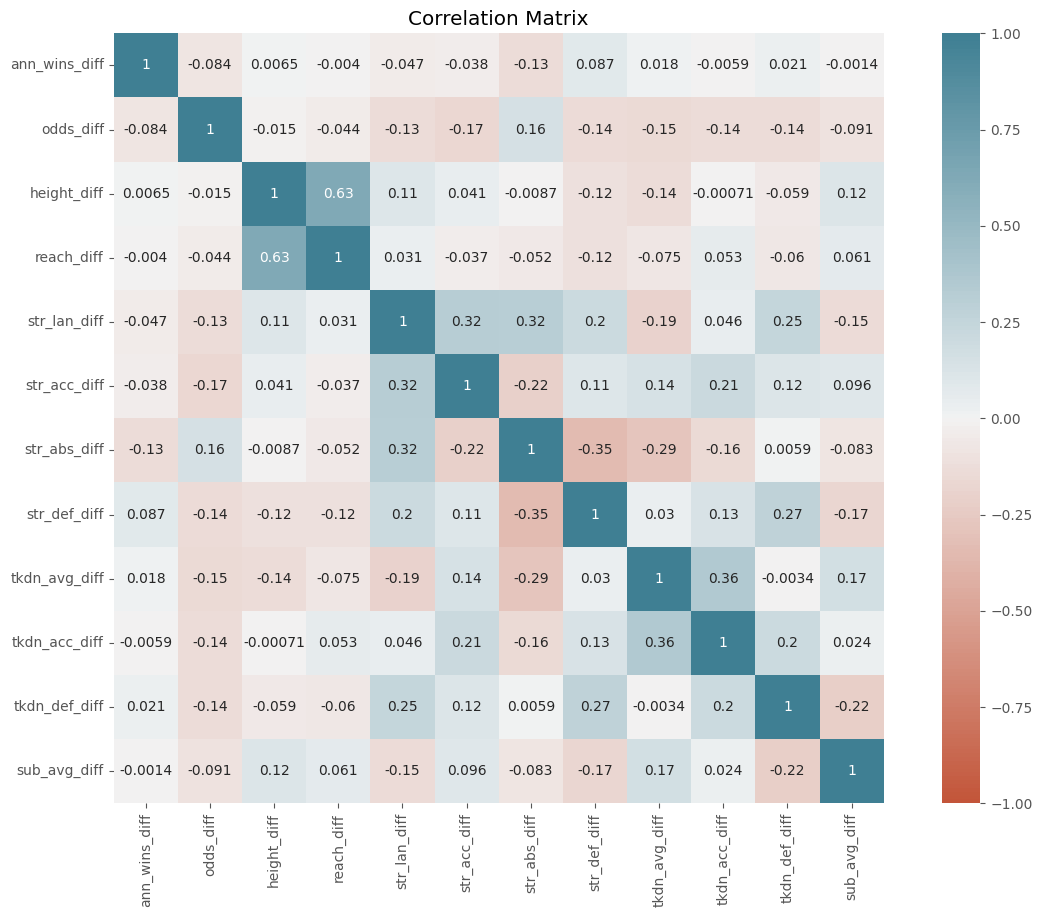

In [56]:
plt.figure(figsize=(15, 10))
plt.title("Correlation Matrix")
sns.heatmap(
    df[numerical_columns].corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

plt.show()

In [57]:
df.head()

date     result  ann_wins_diff  weight           dob         dob_u  \
0 2013-04-27  Favourite              0       8  Jul 19, 1987  Apr 03, 1977   
1 2013-08-17   Underdog              0       7  Nov 25, 1981  Apr 03, 1977   
2 2013-11-16  Favourite             -1       7  Sep 25, 1979  Apr 03, 1977   
3 2014-04-26  Favourite              0       8  Jul 19, 1987  Oct 28, 1979   
4 2019-09-14   Underdog             -1       7  Mar 07, 1992  Oct 28, 1979   

   odds_diff  height_diff  reach_diff  str_lan_diff  str_acc_diff  \
0      -7.87         7.62       27.94          1.21          0.14   
1      -0.88         0.00        7.62          0.49          0.07   
2      -1.70        -2.54        5.08         -0.94         -0.06   
3      -3.81         5.08       20.32          0.56          0.08   
4      -0.07         2.54        2.54          0.65          0.06   

   str_abs_diff  str_def_diff  tkdn_avg_diff  tkdn_acc_diff  tkdn_def_diff  \
0          1.12          0.02          -1.88          -0.14           0.29   
1          1.69         -0.08          -1.80          -0.11          -0.17   
2          1.32          0.01          -0.83          -0.15           0.07   
3         -2.21          0.13          -0.18           0.12           0.35   
4         -1.96         -0.07           0.18           0.05          -0.07   

   sub_avg_diff  stance_f_Southpaw  stance_f_Switch  stance_u_Southpaw  \
0          0.10              False            False               True   
1          0.30              False            False               True   
2         -0.40              False            False               True   
3         -0.40              False            False              False   
4          0.50              False            False              False   

   stance_u_Switch  favourite_0  favourite_1  favourite_2  favourite_3  \
0            False         0.00         0.00         0.00         0.00   
1            False         0.00         0.00         0.00         0.00   
2            False         0.00         0.00         0.00         0.00   
3            False         0.00         0.00         0.00         0.00   
4            False         0.00         0.00         0.00         0.00   

   favourite_4  favourite_5  favourite_6  favourite_7  favourite_8  \
0         0.00         0.00         0.00         0.00         0.00   
1        -1.00         0.00         0.00         0.00         0.00   
2         0.00         0.00         0.00         0.00         1.00   
3         0.00         0.00         0.00         0.00         0.00   
4         0.00         0.00         0.00         0.00         0.00   

   favourite_9  underdog_0  underdog_1  underdog_2  underdog_3  underdog_4  \
0         1.00        0.00        0.00        1.00        0.00        0.00   
1         0.00        0.00        0.00        1.00        0.00        0.00   
2         0.00        0.00        0.00        1.00        0.00        0.00   
3         1.00        0.00        0.00        0.00        0.00        0.00   
4         1.00        0.00        0.00        0.00        0.00        0.00   

   underdog_5  underdog_6  underdog_7  underdog_8  underdog_9  
0        0.00        0.00        0.00        0.00        0.00  
1        0.00        0.00        0.00        0.00        0.00  
2        0.00        0.00        0.00        0.00        0.00  
3        0.00        0.00        0.00       -1.00        0.00  
4        0.00        0.00        0.00       -1.00        0.00

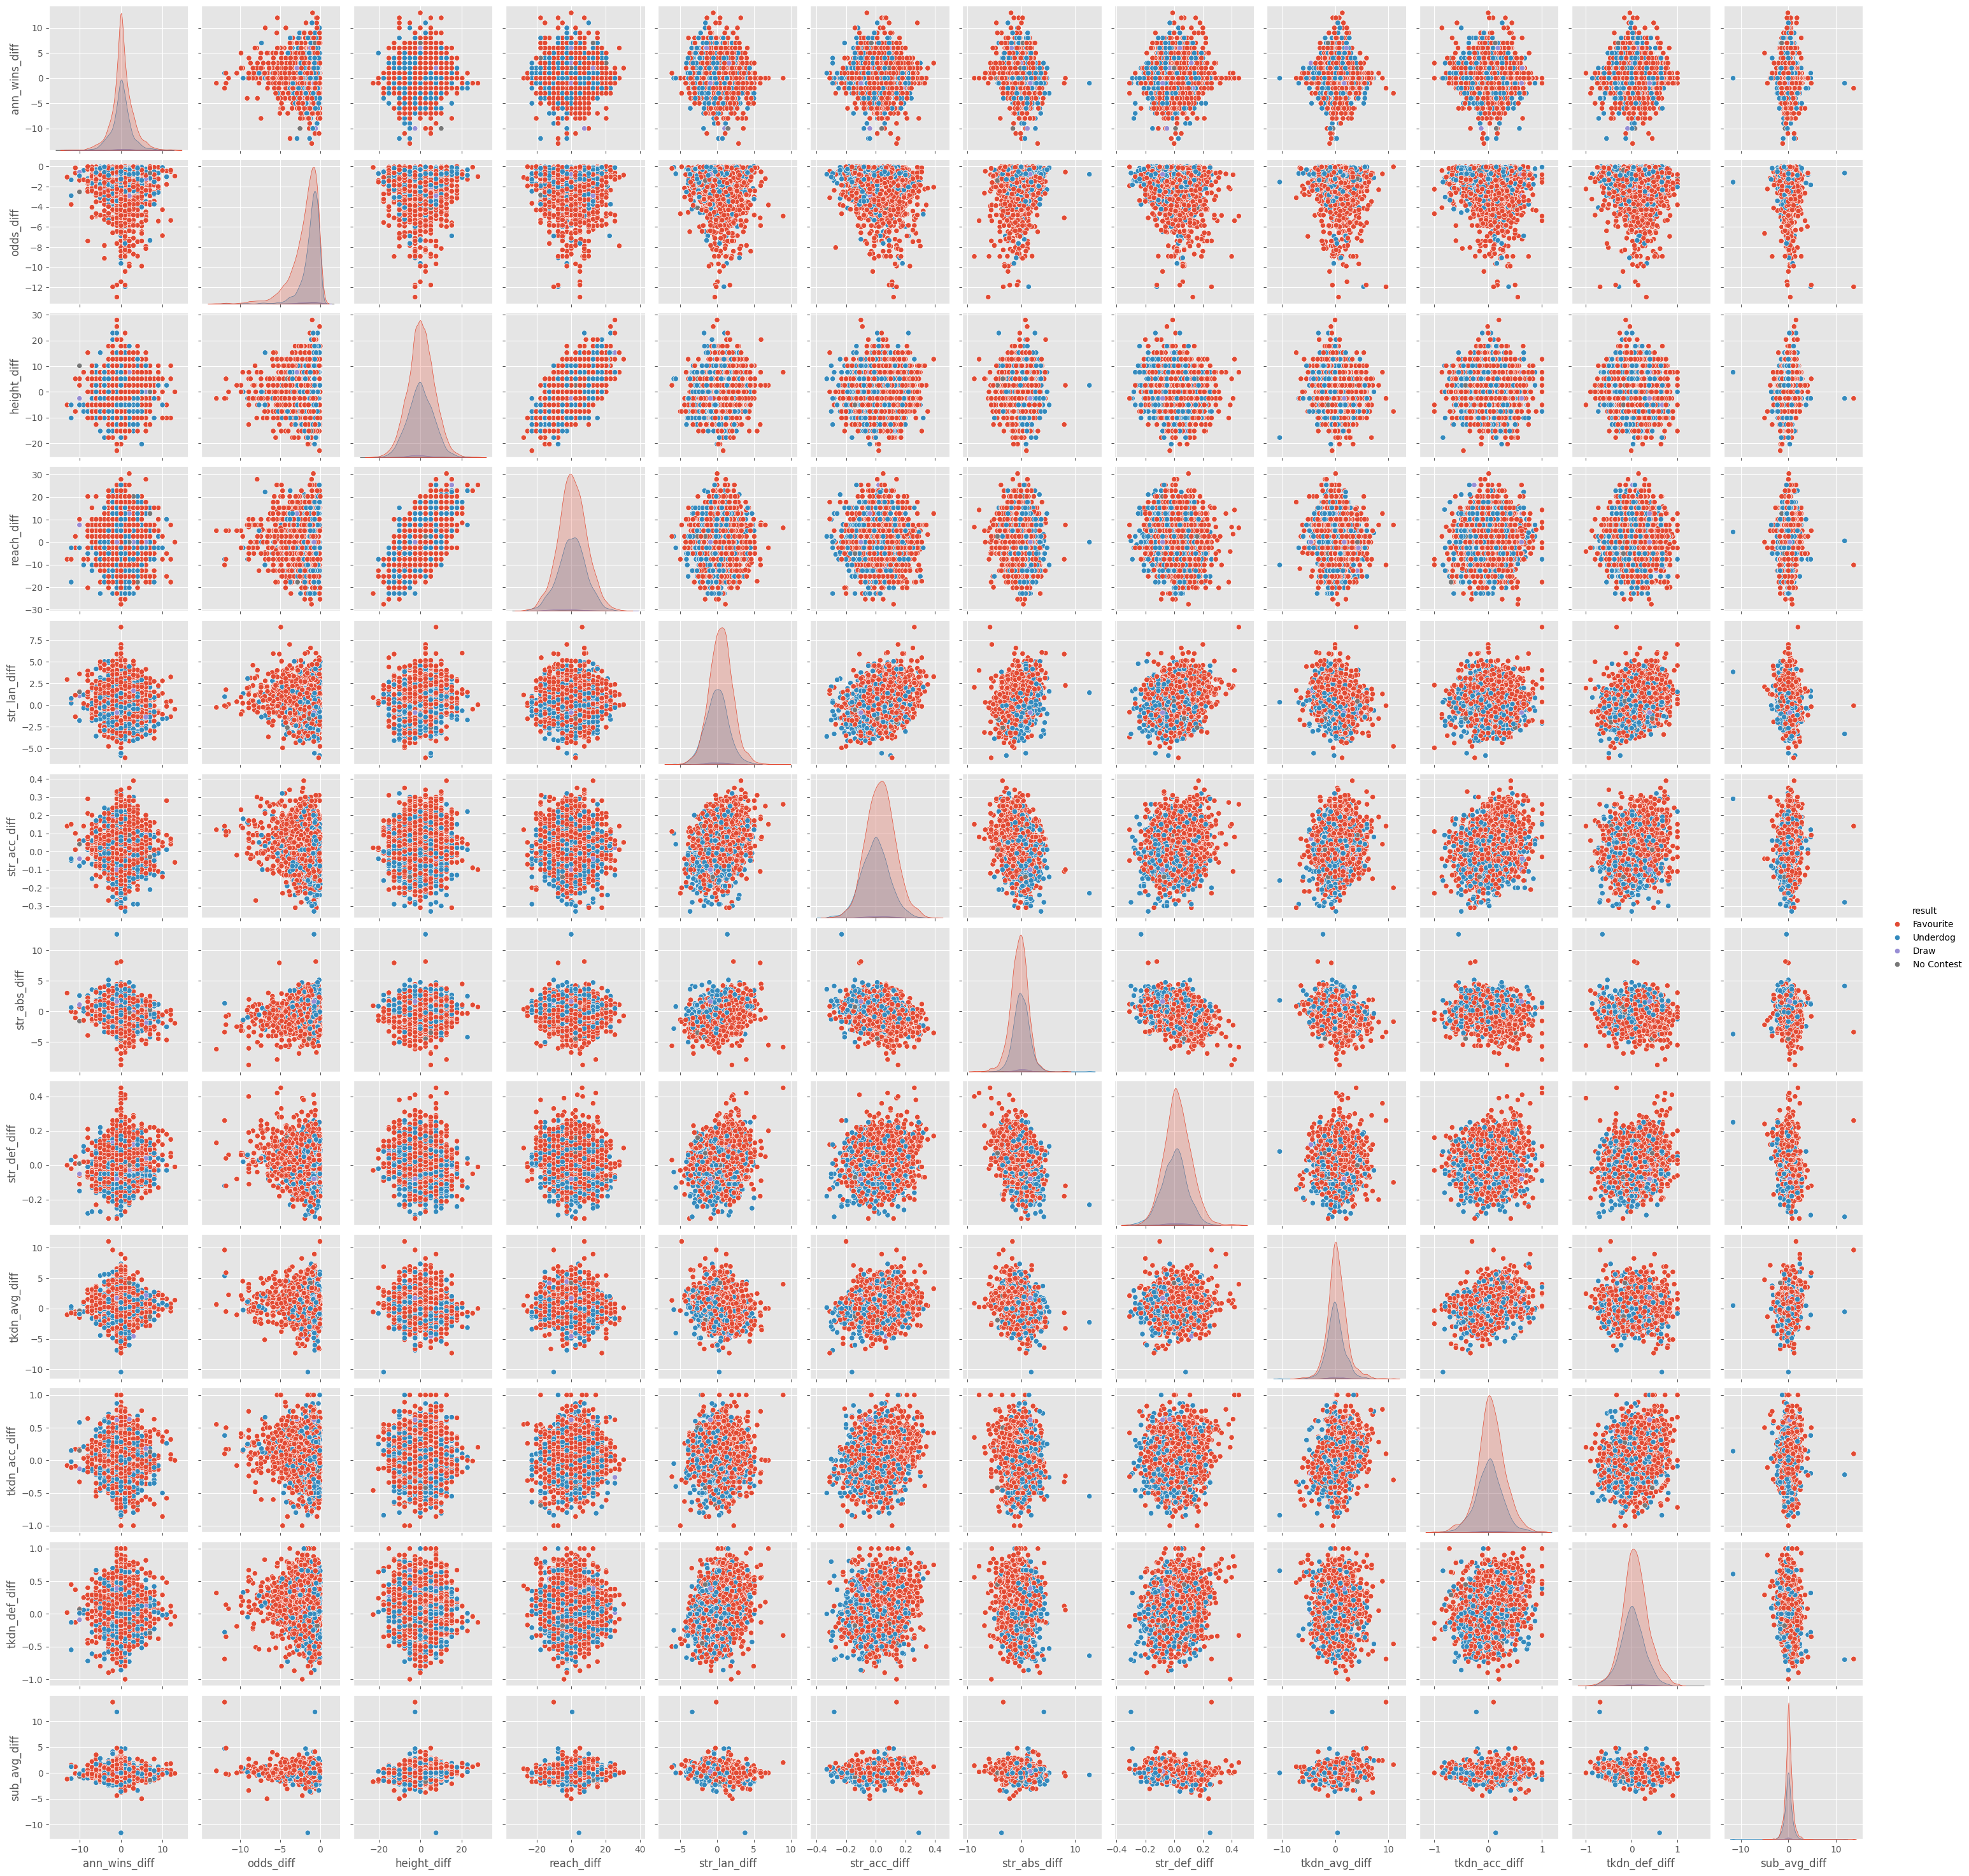

In [58]:
sns.pairplot(df[numerical_columns + ['result']],hue="result")
plt.show()

### Correlating Features

Height difference between favourites and underdogs moderatly positevely correlates with their arm reach difference at 0.63. It makes sense as taller people tend to have longer extremities and vice verse. Striking defence negatevly correlates with amount strikes absorbed at -0.35. The better your defense is the less strikes you miss.

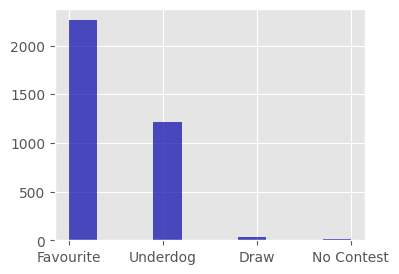

In [59]:
plt.figure(figsize=(4, 3))
plt.hist(df.result, align='mid',rwidth=2, color='#0504aa', alpha=0.7)
plt.show()

#### Given the extreme imbalance in my dataset, I lean towards oversampling Draw and Underdog class.

In [60]:
df.head()

date     result  ann_wins_diff  weight           dob         dob_u  \
0 2013-04-27  Favourite              0       8  Jul 19, 1987  Apr 03, 1977   
1 2013-08-17   Underdog              0       7  Nov 25, 1981  Apr 03, 1977   
2 2013-11-16  Favourite             -1       7  Sep 25, 1979  Apr 03, 1977   
3 2014-04-26  Favourite              0       8  Jul 19, 1987  Oct 28, 1979   
4 2019-09-14   Underdog             -1       7  Mar 07, 1992  Oct 28, 1979   

   odds_diff  height_diff  reach_diff  str_lan_diff  str_acc_diff  \
0      -7.87         7.62       27.94          1.21          0.14   
1      -0.88         0.00        7.62          0.49          0.07   
2      -1.70        -2.54        5.08         -0.94         -0.06   
3      -3.81         5.08       20.32          0.56          0.08   
4      -0.07         2.54        2.54          0.65          0.06   

   str_abs_diff  str_def_diff  tkdn_avg_diff  tkdn_acc_diff  tkdn_def_diff  \
0          1.12          0.02          -1.88          -0.14           0.29   
1          1.69         -0.08          -1.80          -0.11          -0.17   
2          1.32          0.01          -0.83          -0.15           0.07   
3         -2.21          0.13          -0.18           0.12           0.35   
4         -1.96         -0.07           0.18           0.05          -0.07   

   sub_avg_diff  stance_f_Southpaw  stance_f_Switch  stance_u_Southpaw  \
0          0.10              False            False               True   
1          0.30              False            False               True   
2         -0.40              False            False               True   
3         -0.40              False            False              False   
4          0.50              False            False              False   

   stance_u_Switch  favourite_0  favourite_1  favourite_2  favourite_3  \
0            False         0.00         0.00         0.00         0.00   
1            False         0.00         0.00         0.00         0.00   
2            False         0.00         0.00         0.00         0.00   
3            False         0.00         0.00         0.00         0.00   
4            False         0.00         0.00         0.00         0.00   

   favourite_4  favourite_5  favourite_6  favourite_7  favourite_8  \
0         0.00         0.00         0.00         0.00         0.00   
1        -1.00         0.00         0.00         0.00         0.00   
2         0.00         0.00         0.00         0.00         1.00   
3         0.00         0.00         0.00         0.00         0.00   
4         0.00         0.00         0.00         0.00         0.00   

   favourite_9  underdog_0  underdog_1  underdog_2  underdog_3  underdog_4  \
0         1.00        0.00        0.00        1.00        0.00        0.00   
1         0.00        0.00        0.00        1.00        0.00        0.00   
2         0.00        0.00        0.00        1.00        0.00        0.00   
3         1.00        0.00        0.00        0.00        0.00        0.00   
4         1.00        0.00        0.00        0.00        0.00        0.00   

   underdog_5  underdog_6  underdog_7  underdog_8  underdog_9  
0        0.00        0.00        0.00        0.00        0.00  
1        0.00        0.00        0.00        0.00        0.00  
2        0.00        0.00        0.00        0.00        0.00  
3        0.00        0.00        0.00       -1.00        0.00  
4        0.00        0.00        0.00       -1.00        0.00

In [63]:
df.dob.value_counts

<bound method IndexOpsMixin.value_counts of 0       Jul 19, 1987
1       Nov 25, 1981
2       Sep 25, 1979
3       Jul 19, 1987
4       Mar 07, 1992
            ...     
3513    Sep 09, 1998
3514    Feb 05, 1996
3515    Jun 08, 1995
3516    Aug 14, 1992
3517    Jul 04, 1996
Name: dob, Length: 3518, dtype: object>